In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

In [3]:
#with open('wind_angels.pkl','rb') as f:
#    wind_list = pickle.load(f)
#f.close()

wind = pd.read_pickle("MergedWindData.pkl")

frame_width = len(wind['Points_2'].unique())
frame_length = len(wind['Points_0'].unique())
shape=(frame_width, frame_length)

print("shape", shape)
DEM_path = 'data\\normal_surface_bed_original.txt_cut_trim.csv'
DEM = pd.read_csv(DEM_path)

shape (401, 701)


In [21]:
size = 80
nu = 1.5E-5
gravity = -9.81

# Saeb
# h is dune hight. Actually h + 1 is the elevation of meshes that we predict velocity
# h = Points_1

# w is the velocity componenent in dune hight/gravity direction 
# w is read/loaded from CFD results data. wh = U_1
# p is read/loaded from CFD results data

class PINN_NS():
    def __init__(self):
        print("\nNew object initializing")
        self.network()
        self.mse = nn.MSELoss()
        self.loss = 0
        self.loss_hist = []
        self.val_hist = []
        self.uvw_loss = 0
        self.fg_loss = 0
        self.deg = 0
        #self.test_val_split = 0.9
        self.epoch_dict = defaultdict(int)

    def network(self):
        print("New network created")
        self.net = nn.Sequential(
            nn.Linear(7,size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, size), nn.Tanh(),
            nn.Linear(size, 4) 
        )

    def validate(self):
        u_pred, v_pred, w_pred, p_pred, c_pred, m_x_pred, m_y_pred, m_h_pred = self.function(self.val_x, self.val_y, self.val_h, self.val_nx, self.val_ny, self.val_nz, self.val_angle)
        
        u_loss = self.mse(u_pred, self.val_u)
        v_loss = self.mse(v_pred, self.val_v)
        w_loss = self.mse(w_pred, self.val_w)
        

        m_x_loss = self.mse(m_x_pred, self.null)
        m_y_loss = self.mse(m_y_pred, self.null)
        m_h_loss = self.mse(m_h_pred, self.null)
        val_c_loss = self.mse(c_pred, self.null)
        
        val_uvw_loss = u_loss + v_loss + w_loss
        val_m_loss = m_x_loss + m_y_loss + m_x_loss
        self.val_loss = val_c_loss + val_uvw_loss + val_m_loss
        self.val_hist.append(self.val_loss.item())
        

    def function(self, x, y, h, nx, ny, nz, angle, del_graph=False):
        res = self.net(torch.hstack((x, y, h, nx, ny, nz, angle)))
        u, v, w, p = res[:, 0:1], res[:, 1:2], res[:, 2:3] , res[:, 3:4]
               
        if self.use_physics:           
            u_x  = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
            u_y  = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

            u_h  = torch.autograd.grad(u, h, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            u_hh = torch.autograd.grad(u_h, h, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
            v_x  = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
            v_y  = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
            v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    
            v_h  = torch.autograd.grad(v, h, grad_outputs=torch.ones_like(u), create_graph=True)[0]
            v_hh = torch.autograd.grad(v_h, h, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
            p_x  = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
            p_y  = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
            p_h  = torch.autograd.grad(p, h, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
            # compute dune hight related terms
            w_x  = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
            w_xx = torch.autograd.grad(w_x, x, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
            w_y  = torch.autograd.grad(w, y, grad_outputs=torch.ones_like(w), create_graph=True)[0]
            w_yy = torch.autograd.grad(w_y, y, grad_outputs=torch.ones_like(w_y), create_graph=True)[0]
            w_h  = torch.autograd.grad(w, h, grad_outputs=torch.ones_like(w), create_graph=True)[0]
            w_hh = torch.autograd.grad(w_h, h, grad_outputs=torch.ones_like(w_x), create_graph=True)[0]
    
            # add considrartion of continuty (mass conservation equation)
            c = (u_x + v_y + w_h)    
      
            m_x = 0 + (u * u_x) + (v * u_y) + (w * u_h) + p_x - (nu * (u_xx + u_yy + u_hh))           # momentume in x direction    I set u_t =0 since our model is assumed steady-state
            m_y = 0 + (u * v_x) + (v * v_y) + (w * v_h) + p_y - (nu * (v_xx + v_yy + v_hh))           # momentume in y direction    I set v_t =0 since our model is assumed steady-state
            m_h = 0 + (u * w_x) + (v * w_y) + (w * w_h) + p_h - (nu * (w_xx + w_yy + w_hh)) - gravity # momentume in h direction    I set w_t =0 since our model is assumed steady-state
            
        else:
            c = m_x = m_y = m_h = self.null
        
        if del_graph:
            self.optimizer.zero_grad()

        return u, v, w, p, c, m_x, m_y, m_h

    def closure(self):
        self.optimizer.zero_grad()
        
        u_pred, v_pred, w_pred, p_pred, c_pred, m_x_pred, m_y_pred, m_h_pred = self.function(self.x, self.y, self.h, self.nx, self.ny, self.nz, self.angle)
        
        u_loss = self.mse(u_pred, self.u)
        v_loss = self.mse(v_pred, self.v)
        w_loss = self.mse(w_pred, self.w)

        m_x_loss = self.mse(m_x_pred, self.null)
        m_y_loss = self.mse(m_y_pred, self.null)
        m_h_loss = self.mse(m_h_pred, self.null)

        self.c_loss = self.mse(c_pred, self.null)
        self.uvw_loss = u_loss + v_loss + w_loss
        self.m_loss = m_x_loss + m_y_loss + m_x_loss
        self.loss = self.uvw_loss + self.c_loss + self.m_loss

        self.validate()
        
        self.loss.backward()
        
        if not self.epoch_dict[self.deg]%10:
            print('Epoch: {:}, Loss: {:0.6f},\tValidation Loss: {:0.6f}, \tUVW Loss: {:0.6f}, \tC Loss: {:0.6f}, M Loss: {:0.6f}'.format(dict(self.epoch_dict), self.loss, self.val_loss, self.uvw_loss, self.c_loss,  self.m_loss))
            
        self.epoch_dict[self.deg] += 1
        self.loss_hist.append(self.loss.item())
        
        return self.loss

    def load_training_data(self, X, Y, H, NX, NY, NZ, angle, U, V, W):
        print("Loading new training tensors...")
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.h = torch.tensor(H, dtype=torch.float32, requires_grad=True)
        self.nx = torch.tensor(NX, dtype=torch.float32)
        self.ny = torch.tensor(NY, dtype=torch.float32)
        self.nz = torch.tensor(NZ, dtype=torch.float32)
        self.u = torch.tensor(U, dtype=torch.float32)
        self.v = torch.tensor(V, dtype=torch.float32)
        self.w = torch.tensor(W, dtype=torch.float32)
        self.deg = np.arcsin(angle[0,0])*180/np.pi
        self.angle = torch.tensor(angle, dtype=torch.float32)
        self.null = torch.zeros((self.x.shape[0], 1))
        print("New training tensors Loaded!\n")

    def load_validaiton_data(self, X, Y, H, NX, NY, NZ, angle, U, V, W):
        print("Loading new validation tensors...")
        self.val_x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
        self.val_y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
        self.val_h = torch.tensor(H, dtype=torch.float32, requires_grad=True)
        self.val_nx = torch.tensor(NX, dtype=torch.float32)
        self.val_ny = torch.tensor(NY, dtype=torch.float32)
        self.val_nz = torch.tensor(NZ, dtype=torch.float32)
        self.val_u = torch.tensor(U, dtype=torch.float32)
        self.val_v = torch.tensor(V, dtype=torch.float32)
        self.val_w = torch.tensor(W, dtype=torch.float32)
        self.val_deg = np.arcsin(angle[0,0])*180/np.pi
        self.val_angle = torch.tensor(angle, dtype=torch.float32)
        self.val_null = torch.zeros((self.val_x.shape[0], 1))
        print("New validation tensors Loaded!\n")
        
    def train(self, use_physics=True, epochs=100):
        print("Beginning Training..")
        self.use_physics = use_physics
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), lr=1, max_iter=epochs, max_eval=None, tolerance_grad=1e-07,
            tolerance_change=1e-09, history_size=250, line_search_fn="strong_wolfe")#changes history size
        print("\tNew Optimizer Created.")
        #self.optimizer.zero_grad() #delete this line later
        print("Traing:\tUse Physics=", self.use_physics, "\tEpochs = ", epochs, "\tTraining Angle = ", self.deg)
        
        self.net.train()
        self.optimizer.step(self.closure)

    def get_lost(self):
        return self.loss_hist, self.val_hist

In [22]:
def get_preprocessed_data(w_indicies, N_points=5000, testing=False):
    
    angles_to_match = list(map(lambda x: 10*x-70, w_indicies)) #load_validaiton_data
    print("angles_to_match =", angles_to_match)
    selected_wind = wind[np.isin(wind['angle'], angles_to_match)]

    
    #Extracting data from dataframe
    Points_0 = selected_wind['Points_0'].to_numpy()
    Points_1 = selected_wind['Points_1'].to_numpy()
    Points_2 = selected_wind['Points_2'].to_numpy()
    #pressure = w_index['p'].to_numpy()
    
    #Scaling the coords
    scale_land_by = 64
    Points_0 = (Points_0-Points_0.mean())/scale_land_by
    Points_1 = (Points_1-Points_1.mean())/scale_land_by
    Points_2 = (Points_2-Points_2.mean())/scale_land_by
    
    #digital elevation
    dem_x = DEM['nx'].to_numpy()
    dem_y = DEM['ny'].to_numpy()
    dem_z = DEM['nz'].to_numpy()
    
    #Scaling the U V W data
    UV_scale_factor = 64 #Here I want to center the velocities but I # them out because this will destroy the physics
    U_0_mean = 0 #selected_wind.groupby('angle')['U_0'].transform('mean')
    U_1_mean = 0 #selected_wind.groupby('angle')['U_1'].transform('mean')
    U_2_mean = 0 #selected_wind.groupby('angle')['U_2'].transform('mean')
    U_0 = np.array((selected_wind['U_0']-U_0_mean)/UV_scale_factor)
    U_1 = np.array((selected_wind['U_1']-U_0_mean)/UV_scale_factor)
    U_2 = np.array((selected_wind['U_2']-U_0_mean)/UV_scale_factor)


    #Get Angle vector
    sin_angle = np.array(np.sin(selected_wind['angle']*np.pi/180))
    
    
    if testing:
        return Points_0, Points_1, Points_2, dem_x, dem_y, dem_z, sin_angle, U_0, U_2, U_1 #Here we swap U_2 and U_1 because U_2 is y, U_1 is h
    
    #sampling the available training data
    N_train = 50_000                     
    data_length = len(selected_wind)
    
    idx = np.random.choice(data_length, N_train, replace=False)
    dem_idx = idx%len(DEM)
    
    x_train = Points_0[idx, None]
    y_train = Points_2[idx, None]
    h_train = Points_1[idx, None]
    nx_train = dem_x[dem_idx, None]
    ny_train = dem_y[dem_idx, None]
    nz_train = dem_z[dem_idx, None]
    sin_angle_train = sin_angle[idx, None]
    u_train = U_0[idx, None] 
    v_train = U_2[idx, None] #note v <- U_2
    w_train = U_1[idx, None] #note w <- U_1

    return x_train, y_train, h_train, nx_train, ny_train, nz_train, sin_angle_train, u_train, v_train, w_train

In [28]:
#PINN = PINN_NS()
PINN.load_training_data(*get_preprocessed_data([7]))
PINN.load_validaiton_data(*get_preprocessed_data([7]))
PINN.train(use_physics=False, epochs=1E4) # Set use_physics=True to calculate C, Mx, My, Mh in the loss function

angles_to_match = [0]
Loading new training tensors...
New training tensors Loaded!

angles_to_match = [0]
Loading new validation tensors...
New validation tensors Loaded!

Beginning Training..
	New Optimizer Created.
Traing:	Use Physics= False 	Epochs =  10000.0 	Training Angle =  0.0
Epoch: {0.0: 770}, Loss: 0.002341,	Validation Loss: 0.002316, 	UVW Loss: 0.002341, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 780}, Loss: 0.002330,	Validation Loss: 0.002307, 	UVW Loss: 0.002330, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 790}, Loss: 0.002317,	Validation Loss: 0.002296, 	UVW Loss: 0.002317, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 800}, Loss: 0.002304,	Validation Loss: 0.002286, 	UVW Loss: 0.002304, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 810}, Loss: 0.002289,	Validation Loss: 0.002271, 	UVW Loss: 0.002289, 	C Loss: 0.000000, M Loss: 0.000000
Epoch: {0.0: 820}, Loss: 0.002273,	Validation Loss: 0.002254, 	UVW Loss: 0.002273, 	C Loss: 0.000000, M Loss: 0.000000


KeyboardInterrupt: 

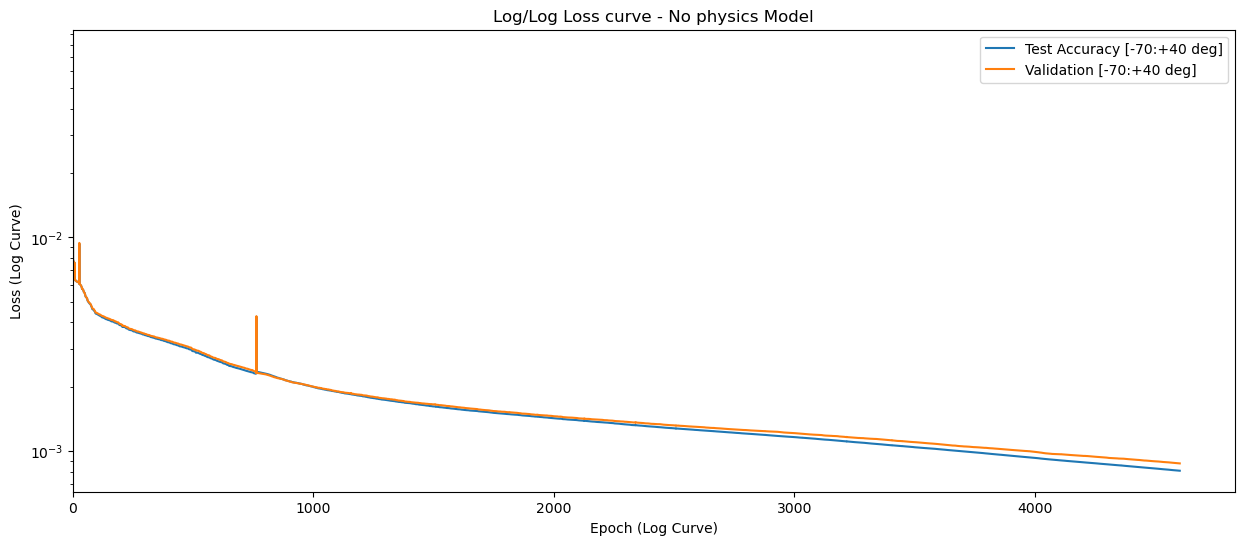

In [29]:
plt.figure(figsize=(15,6))
hist, val_hist = PINN.get_lost()
capped_list = [min(value, val_hist[0]*1.2) for value in hist]
val_list = [min(value, val_hist[0]*1.2) for value in val_hist]
plt.plot(capped_list, label='Test Accuracy [+0 deg]')
plt.plot(val_list, label='Validation [+0 deg]')
plt.xlim(0,)
#plt.ylim(0.01,1)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Epoch (Log Curve)')
plt.ylabel('Loss (Log Curve)')
plt.title('Log/Log Loss curve - No physics Model')
plt.legend(loc='upper right')
#plt.savefig("LogLoss Curve with Validation(0 deg), No physics Model(-10+10deg).png")
plt.show()

In [30]:
#torch.save(PINN, './models/model.pt')
#PINN = torch.load('./models/model.pt')

In [31]:
#get the preprocessed data and true U values
*preprocessed_data,  U_0, U_1, U_2 = get_preprocessed_data([7], testing=True)

#convert preprocessed data to tensors of the correct shape
preprocessed_data = tuple([torch.tensor(item.reshape(-1,1), dtype=torch.float32, requires_grad=True) for item in preprocessed_data])

NN_out = PINN.net(torch.hstack((preprocessed_data)))
u_pred = NN_out[:, 0].data.cpu().numpy().reshape(shape)
v_pred = NN_out[:, 1].data.cpu().numpy().reshape(shape)
w_pred = NN_out[:, 2].data.cpu().numpy().reshape(shape)
#u_pred,v_pred, w_pred = [i.data.cpu().numpy().reshape(shape) for i in PINN.function(*preprocessed_data, del_graph=True)[:3]]

angles_to_match = [0]


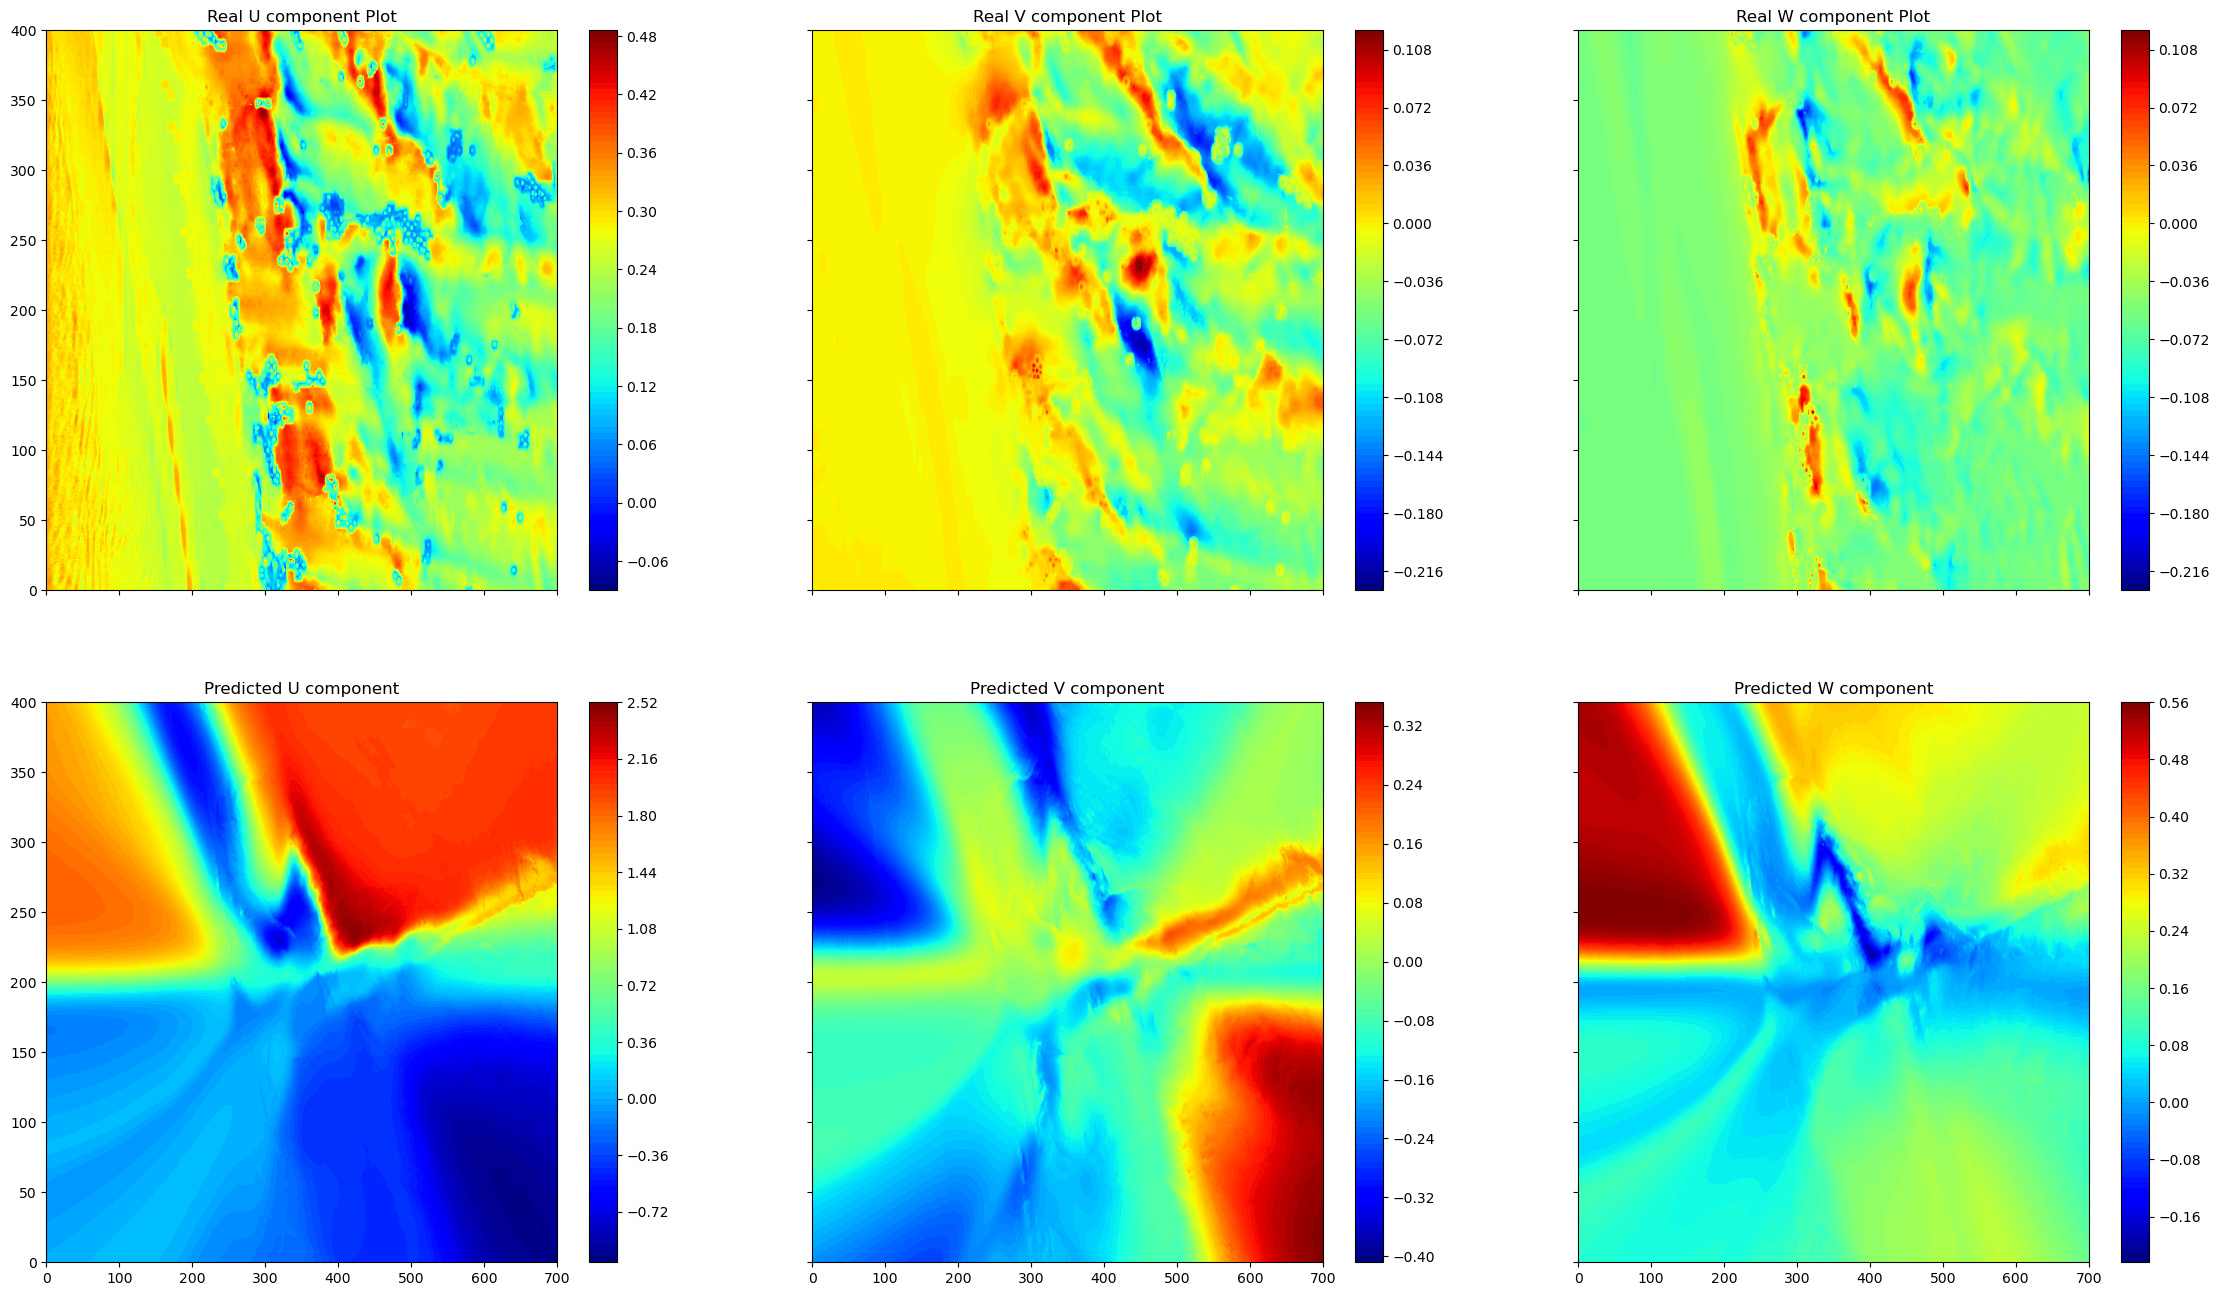

In [32]:
fig, axs = plt.subplots(2,3,  figsize=(28,16), sharex=True, sharey=True)

## Truth Data
p1 = axs[0,0].contourf(U_0.reshape(shape), levels=100, cmap='jet')
fig.colorbar(p1, ax=axs[0,0])
axs[0,0].title.set_text('Real U component Plot')
    
    
p2 = axs[0,1].contourf(U_1.reshape(shape), levels=100, cmap='jet')
fig.colorbar(p2, ax=axs[0,1])
axs[0,1].title.set_text('Real V component Plot')

p3 = axs[0,2].contourf(U_2.reshape(shape), levels=100, cmap='jet')
fig.colorbar(p2, ax=axs[0,2])
axs[0,2].title.set_text('Real W component Plot')


## Prediction Data
p4 = axs[1,0].contourf(u_pred, levels=100, cmap='jet')
fig.colorbar(p4, ax=axs[1,0])
axs[1,0].title.set_text('Predicted U component')
    
    
p5 = axs[1,1].contourf(v_pred, levels=100, cmap='jet')
fig.colorbar(p5, ax=axs[1,1])
axs[1,1].title.set_text('Predicted V component')

p6 = axs[1,2].contourf(w_pred, levels=100, cmap='jet')
fig.colorbar(p6, ax=axs[1,2])
axs[1,2].title.set_text('Predicted W component')


#plt.savefig("5k_training_with_DEM_Nxyz_with_U123.png", dpi=300) 
